In [0]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
from keras.applications import vgg19
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
import tensorflow as tf
import keras

Using TensorFlow backend.


In [0]:
!wget https://www.dropbox.com/s/aqdoilzpclo59il/style%20image.png
!wget https://www.dropbox.com/s/h7b1hn6ck4xmeuf/cat.png 

In [0]:
import cv2

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

(-0.5, 223.5, 223.5, -0.5)

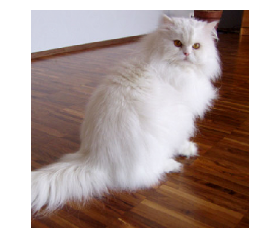

In [0]:
base_img = cv2.imread('/content/cat.png')
base_img = cv2.cvtColor(base_img, cv2.COLOR_BGR2RGB)
base_img = cv2.resize(base_img,(224,224))
plt.imshow(base_img)
plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

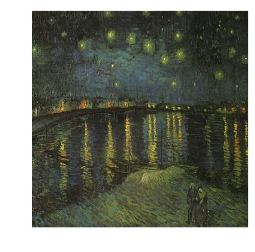

In [0]:
style_img = cv2.imread('/content/style image.png')
style_img = cv2.cvtColor(style_img, cv2.COLOR_BGR2RGB)
style_img = cv2.resize(style_img,(224,224))
plt.imshow(style_img)
plt.axis('off')

In [0]:
from keras.applications import vgg19

In [0]:
K.set_learning_phase(0)
model = vgg19.VGG19(include_top=False, weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [0]:
base_img = base_img.reshape(1,224,224,3)/255

In [0]:
from keras import backend as K

# with a Sequential model
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.get_layer('block3_conv4').output])
layer_output_base = get_3rd_layer_output([base_img])[0]

In [0]:
layer_output_base.shape

(1, 56, 56, 256)

In [0]:
layer_contributions_content = {
'block3_conv4': 0.1
}

In [0]:
layer_contributions_style = {
    'block1_pool':1,
   'block2_pool':1,
'block3_conv4': 1,
}

In [0]:
img_nrows = 224
img_ncols = 224

In [0]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4. * (pow(channels,2)) * (pow(size,2)))

In [0]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
loss = K.variable(0.)
for layer_name in layer_contributions_content:
  coeff = layer_contributions_content[layer_name]
  activation = layer_dict[layer_name].output
  scaling = K.prod(K.cast(K.shape(activation), 'float32'))
  loss += coeff * K.sum(K.square(activation - layer_output_base)) / scaling
  
for layer_name in layer_contributions_style:
  coeff = layer_contributions_style[layer_name]
  activation = layer_dict[layer_name].output
  scaling = K.prod(K.cast(K.shape(activation), 'float32'))
  style_layer_output = K.function([model.layers[0].input],[model.get_layer(layer_name).output])
  layer_output_style = style_layer_output([style_img.reshape(1,224,224,3)/255])[0][0]
  loss += style_loss(layer_output_style, activation[0])

In [0]:
dream = model.input
grads = K.gradients(loss, dream)[0]
print(dream)
print(grads)

Tensor("input_1:0", shape=(?, ?, ?, 3), dtype=float32)
Tensor("gradients/block1_conv1/convolution_grad/Conv2DBackpropInput:0", shape=(?, ?, ?, 3), dtype=float32)


In [0]:
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

In [0]:
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

In [0]:
def eval_loss_and_grads(x):
  outs = fetch_loss_and_grads([x])
  loss_value = outs[0]
  grad_values = outs[1]
  return loss_value, grad_values

In [0]:
def gradient_ascent(x, iterations, step, max_loss=None):
  for i in range(iterations):
    loss_value, grad_values = eval_loss_and_grads(x)
    print('...Loss value at', i, ':', loss_value)
    x -= step * grad_values
  return x

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
base_img.shape

(1, 224, 224, 3)

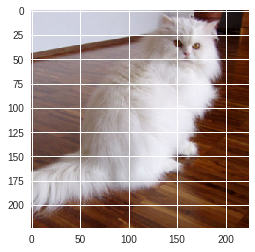

In [0]:
plt.imshow(base_img[0,:,:,:])

In [0]:
img = base_img.copy().reshape(1,224,224,3).astype('float32')

...Loss value at 0 : 34735.33


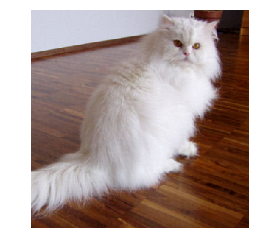

...Loss value at 1 : 30681.723
...Loss value at 2 : 26875.69
...Loss value at 3 : 23384.025
...Loss value at 4 : 20264.266
...Loss value at 5 : 17520.502
...Loss value at 6 : 15139.493
...Loss value at 7 : 13092.2
...Loss value at 8 : 11329.82
...Loss value at 9 : 9809.833
...Loss value at 10 : 8511.641
...Loss value at 11 : 7410.9062
...Loss value at 12 : 6485.706
...Loss value at 13 : 5706.6514
...Loss value at 14 : 5038.6577
...Loss value at 15 : 4453.249
...Loss value at 16 : 3932.731
...Loss value at 17 : 3465.7722
...Loss value at 18 : 3042.868
...Loss value at 19 : 2663.881
...Loss value at 20 : 2326.559
...Loss value at 21 : 2031.3185
...Loss value at 22 : 1776.7981
...Loss value at 23 : 1561.0934
...Loss value at 24 : 1384.2834
...Loss value at 25 : 1286.2467
...Loss value at 26 : 1301.0687
...Loss value at 27 : 1215.0974
...Loss value at 28 : 1213.2582
...Loss value at 29 : 1151.7399
...Loss value at 30 : 1142.6738
...Loss value at 31 : 1095.9983
...Loss value at 32 : 1083.75

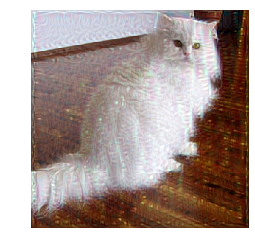

...Loss value at 101 : 484.62778
...Loss value at 102 : 489.468
...Loss value at 103 : 478.7864
...Loss value at 104 : 483.68726
...Loss value at 105 : 473.06897
...Loss value at 106 : 478.21515
...Loss value at 107 : 467.4027
...Loss value at 108 : 472.97247
...Loss value at 109 : 462.10303
...Loss value at 110 : 467.72772
...Loss value at 111 : 457.05347
...Loss value at 112 : 462.87103
...Loss value at 113 : 452.07547
...Loss value at 114 : 458.03302
...Loss value at 115 : 447.19498
...Loss value at 116 : 453.45422
...Loss value at 117 : 442.6208
...Loss value at 118 : 448.9958
...Loss value at 119 : 438.06317
...Loss value at 120 : 444.682
...Loss value at 121 : 433.7133
...Loss value at 122 : 440.4037
...Loss value at 123 : 429.5546
...Loss value at 124 : 436.44376
...Loss value at 125 : 425.37402
...Loss value at 126 : 432.45425
...Loss value at 127 : 421.4511
...Loss value at 128 : 428.52673
...Loss value at 129 : 417.65378
...Loss value at 130 : 424.8075
...Loss value at 131 : 

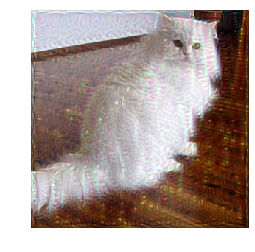

...Loss value at 201 : 335.25586
...Loss value at 202 : 328.72617
...Loss value at 203 : 333.32196
...Loss value at 204 : 326.72852
...Loss value at 205 : 331.55792
...Loss value at 206 : 324.78607
...Loss value at 207 : 329.6608
...Loss value at 208 : 323.02515
...Loss value at 209 : 328.004
...Loss value at 210 : 321.14893
...Loss value at 211 : 326.31384
...Loss value at 212 : 319.5307
...Loss value at 213 : 324.60507
...Loss value at 214 : 317.8605
...Loss value at 215 : 322.99268
...Loss value at 216 : 316.20032
...Loss value at 217 : 321.52527
...Loss value at 218 : 314.61383
...Loss value at 219 : 319.95468
...Loss value at 220 : 313.11548
...Loss value at 221 : 318.3305
...Loss value at 222 : 311.67096
...Loss value at 223 : 316.99066
...Loss value at 224 : 310.1159
...Loss value at 225 : 315.58588
...Loss value at 226 : 308.60522
...Loss value at 227 : 314.20508
...Loss value at 228 : 307.1412
...Loss value at 229 : 312.9213
...Loss value at 230 : 305.6977
...Loss value at 231

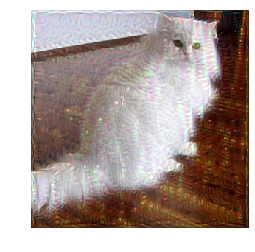

...Loss value at 301 : 270.1694
...Loss value at 302 : 275.96667
...Loss value at 303 : 269.9787
...Loss value at 304 : 275.86838
...Loss value at 305 : 269.48386
...Loss value at 306 : 275.46893
...Loss value at 307 : 268.3166
...Loss value at 308 : 274.69183
...Loss value at 309 : 267.01245
...Loss value at 310 : 273.81433
...Loss value at 311 : 265.92615
...Loss value at 312 : 272.7419
...Loss value at 313 : 264.8058
...Loss value at 314 : 271.8103
...Loss value at 315 : 263.7825
...Loss value at 316 : 270.84204
...Loss value at 317 : 262.81116
...Loss value at 318 : 269.9622
...Loss value at 319 : 261.91254
...Loss value at 320 : 268.88995
...Loss value at 321 : 261.2113
...Loss value at 322 : 267.78082
...Loss value at 323 : 260.4667
...Loss value at 324 : 266.68176
...Loss value at 325 : 259.8858
...Loss value at 326 : 265.6635
...Loss value at 327 : 259.1123
...Loss value at 328 : 264.6009
...Loss value at 329 : 258.4863
...Loss value at 330 : 263.60605
...Loss value at 331 : 25

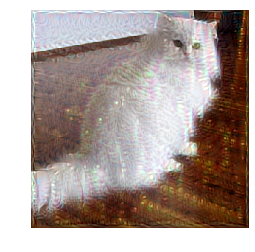

...Loss value at 401 : 247.60257
...Loss value at 402 : 237.30368
...Loss value at 403 : 246.91356
...Loss value at 404 : 236.44016
...Loss value at 405 : 246.07883
...Loss value at 406 : 235.58058
...Loss value at 407 : 244.98505
...Loss value at 408 : 234.73506
...Loss value at 409 : 243.97818
...Loss value at 410 : 233.82205
...Loss value at 411 : 242.95818
...Loss value at 412 : 233.0097
...Loss value at 413 : 241.97305
...Loss value at 414 : 232.264
...Loss value at 415 : 241.04182
...Loss value at 416 : 231.5645
...Loss value at 417 : 240.32385
...Loss value at 418 : 230.86942
...Loss value at 419 : 239.49622
...Loss value at 420 : 230.2957
...Loss value at 421 : 238.71713
...Loss value at 422 : 229.72443
...Loss value at 423 : 238.08076
...Loss value at 424 : 229.22586
...Loss value at 425 : 237.54927
...Loss value at 426 : 228.87766
...Loss value at 427 : 237.02193
...Loss value at 428 : 228.7348
...Loss value at 429 : 236.5236
...Loss value at 430 : 228.55875
...Loss value at 

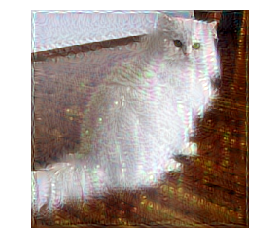

...Loss value at 501 : 226.33072
...Loss value at 502 : 211.43073
...Loss value at 503 : 225.71207
...Loss value at 504 : 211.4371
...Loss value at 505 : 225.15813
...Loss value at 506 : 211.30635
...Loss value at 507 : 224.80222
...Loss value at 508 : 211.30988
...Loss value at 509 : 224.40163
...Loss value at 510 : 211.50699
...Loss value at 511 : 223.97923
...Loss value at 512 : 211.47066
...Loss value at 513 : 223.54019
...Loss value at 514 : 211.30666
...Loss value at 515 : 223.1595
...Loss value at 516 : 211.27318
...Loss value at 517 : 222.69644
...Loss value at 518 : 211.1312
...Loss value at 519 : 222.38431
...Loss value at 520 : 211.05789
...Loss value at 521 : 222.109
...Loss value at 522 : 211.26984
...Loss value at 523 : 222.08456
...Loss value at 524 : 211.67683
...Loss value at 525 : 222.4272
...Loss value at 526 : 212.21713
...Loss value at 527 : 222.95842
...Loss value at 528 : 212.42038
...Loss value at 529 : 223.05678
...Loss value at 530 : 211.85619
...Loss value at

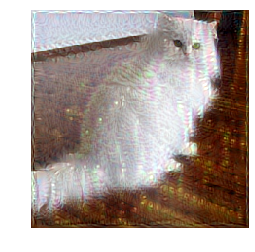

...Loss value at 601 : 202.21498
...Loss value at 602 : 204.85269
...Loss value at 603 : 201.95624
...Loss value at 604 : 204.48245
...Loss value at 605 : 201.73048
...Loss value at 606 : 204.17831
...Loss value at 607 : 201.48212
...Loss value at 608 : 203.80487
...Loss value at 609 : 201.36285
...Loss value at 610 : 203.35246
...Loss value at 611 : 201.22398
...Loss value at 612 : 202.93027
...Loss value at 613 : 201.03384
...Loss value at 614 : 202.57921
...Loss value at 615 : 200.74739
...Loss value at 616 : 202.1752
...Loss value at 617 : 200.66025
...Loss value at 618 : 201.75363
...Loss value at 619 : 200.38297
...Loss value at 620 : 201.47192
...Loss value at 621 : 200.04753
...Loss value at 622 : 201.09314
...Loss value at 623 : 199.94724
...Loss value at 624 : 200.55977
...Loss value at 625 : 199.69785
...Loss value at 626 : 200.16481
...Loss value at 627 : 199.36377
...Loss value at 628 : 199.71823
...Loss value at 629 : 199.10077
...Loss value at 630 : 199.32475
...Loss val

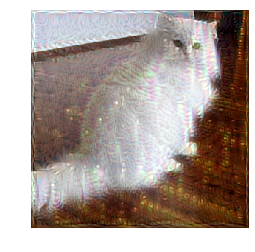

...Loss value at 701 : 199.12186
...Loss value at 702 : 188.61661
...Loss value at 703 : 198.69667
...Loss value at 704 : 188.72684
...Loss value at 705 : 198.31046
...Loss value at 706 : 188.7815
...Loss value at 707 : 197.73004
...Loss value at 708 : 189.07507
...Loss value at 709 : 197.1301
...Loss value at 710 : 189.20197
...Loss value at 711 : 196.58658
...Loss value at 712 : 189.36008
...Loss value at 713 : 195.95192
...Loss value at 714 : 189.37755
...Loss value at 715 : 195.28699
...Loss value at 716 : 189.56305
...Loss value at 717 : 194.6304
...Loss value at 718 : 189.58437
...Loss value at 719 : 194.02258
...Loss value at 720 : 189.6666
...Loss value at 721 : 193.42337
...Loss value at 722 : 189.81
...Loss value at 723 : 192.80022
...Loss value at 724 : 189.89517
...Loss value at 725 : 192.35612
...Loss value at 726 : 190.10968
...Loss value at 727 : 191.73613
...Loss value at 728 : 190.43942
...Loss value at 729 : 191.15788
...Loss value at 730 : 190.87096
...Loss value at 

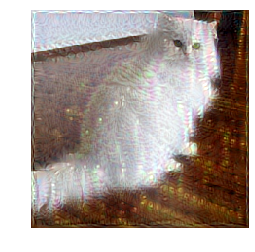

...Loss value at 801 : 184.4007
...Loss value at 802 : 185.83432
...Loss value at 803 : 184.45541
...Loss value at 804 : 185.46371
...Loss value at 805 : 184.51598
...Loss value at 806 : 185.27301
...Loss value at 807 : 184.63802
...Loss value at 808 : 185.25677
...Loss value at 809 : 184.74692
...Loss value at 810 : 185.42354
...Loss value at 811 : 184.95676
...Loss value at 812 : 185.73001
...Loss value at 813 : 184.97824
...Loss value at 814 : 185.98462
...Loss value at 815 : 184.74431
...Loss value at 816 : 186.08737
...Loss value at 817 : 184.15817
...Loss value at 818 : 186.30724
...Loss value at 819 : 183.37083
...Loss value at 820 : 186.7307
...Loss value at 821 : 182.6579
...Loss value at 822 : 187.17725
...Loss value at 823 : 181.92014
...Loss value at 824 : 187.30984
...Loss value at 825 : 180.9697
...Loss value at 826 : 187.15237
...Loss value at 827 : 180.2675
...Loss value at 828 : 186.79846
...Loss value at 829 : 179.89203
...Loss value at 830 : 186.69907
...Loss value a

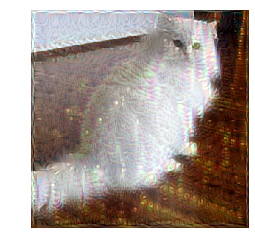

...Loss value at 901 : 177.97546
...Loss value at 902 : 175.79242
...Loss value at 903 : 177.61707
...Loss value at 904 : 175.72162
...Loss value at 905 : 177.38591
...Loss value at 906 : 175.62173
...Loss value at 907 : 177.05017
...Loss value at 908 : 175.647
...Loss value at 909 : 176.62088
...Loss value at 910 : 175.4921
...Loss value at 911 : 176.31638
...Loss value at 912 : 175.40553
...Loss value at 913 : 175.9365
...Loss value at 914 : 175.3353
...Loss value at 915 : 175.54893
...Loss value at 916 : 175.12122
...Loss value at 917 : 175.24182
...Loss value at 918 : 174.96687
...Loss value at 919 : 174.8859
...Loss value at 920 : 174.81497
...Loss value at 921 : 174.58316
...Loss value at 922 : 174.62012
...Loss value at 923 : 174.2297
...Loss value at 924 : 174.41217
...Loss value at 925 : 173.87976
...Loss value at 926 : 174.28934
...Loss value at 927 : 173.69235
...Loss value at 928 : 174.13582
...Loss value at 929 : 173.64252
...Loss value at 930 : 174.04138
...Loss value at 

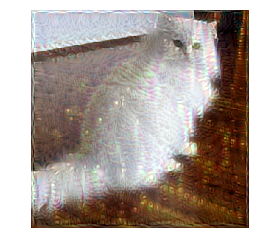

...Loss value at 1001 : 177.25522
...Loss value at 1002 : 167.58022
...Loss value at 1003 : 177.9362
...Loss value at 1004 : 167.60919
...Loss value at 1005 : 178.83145
...Loss value at 1006 : 167.43576
...Loss value at 1007 : 179.4878
...Loss value at 1008 : 167.02737
...Loss value at 1009 : 179.79037
...Loss value at 1010 : 166.4964
...Loss value at 1011 : 180.01584
...Loss value at 1012 : 165.93205
...Loss value at 1013 : 180.15843
...Loss value at 1014 : 165.25357
...Loss value at 1015 : 180.3233
...Loss value at 1016 : 164.52997
...Loss value at 1017 : 180.46307
...Loss value at 1018 : 163.88628
...Loss value at 1019 : 180.37451
...Loss value at 1020 : 163.22972
...Loss value at 1021 : 180.47775
...Loss value at 1022 : 162.64035
...Loss value at 1023 : 180.38828
...Loss value at 1024 : 162.1073
...Loss value at 1025 : 180.36194
...Loss value at 1026 : 161.58148
...Loss value at 1027 : 180.2692
...Loss value at 1028 : 161.02036
...Loss value at 1029 : 180.1074
...Loss value at 1030

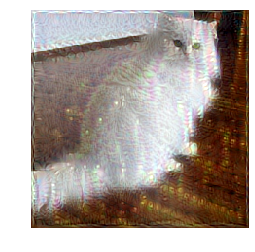

...Loss value at 1101 : 176.24017
...Loss value at 1102 : 158.04185
...Loss value at 1103 : 176.00583
...Loss value at 1104 : 158.30865
...Loss value at 1105 : 175.95605
...Loss value at 1106 : 158.53584
...Loss value at 1107 : 175.8358
...Loss value at 1108 : 158.91238
...Loss value at 1109 : 175.86914
...Loss value at 1110 : 159.22981
...Loss value at 1111 : 175.85861
...Loss value at 1112 : 159.61325
...Loss value at 1113 : 175.9949
...Loss value at 1114 : 159.98776
...Loss value at 1115 : 175.9317
...Loss value at 1116 : 160.24622
...Loss value at 1117 : 175.88434
...Loss value at 1118 : 160.38351
...Loss value at 1119 : 175.80232
...Loss value at 1120 : 160.23672
...Loss value at 1121 : 175.47626
...Loss value at 1122 : 160.01028
...Loss value at 1123 : 175.02698
...Loss value at 1124 : 159.5906
...Loss value at 1125 : 174.57195
...Loss value at 1126 : 159.1803
...Loss value at 1127 : 174.03387
...Loss value at 1128 : 158.74881
...Loss value at 1129 : 173.79224
...Loss value at 11

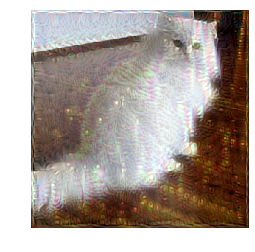

...Loss value at 1201 : 166.35776
...Loss value at 1202 : 158.7466
...Loss value at 1203 : 166.23022
...Loss value at 1204 : 158.1721
...Loss value at 1205 : 165.98267
...Loss value at 1206 : 157.70236
...Loss value at 1207 : 165.65201
...Loss value at 1208 : 157.23886
...Loss value at 1209 : 165.3577
...Loss value at 1210 : 156.91339
...Loss value at 1211 : 165.20212
...Loss value at 1212 : 156.47409
...Loss value at 1213 : 165.04778
...Loss value at 1214 : 156.08601
...Loss value at 1215 : 164.82239
...Loss value at 1216 : 155.86319
...Loss value at 1217 : 164.78644
...Loss value at 1218 : 155.78558
...Loss value at 1219 : 164.7646
...Loss value at 1220 : 155.9798
...Loss value at 1221 : 165.08289
...Loss value at 1222 : 156.54382
...Loss value at 1223 : 165.86105
...Loss value at 1224 : 157.5077
...Loss value at 1225 : 167.13058
...Loss value at 1226 : 158.7617
...Loss value at 1227 : 168.50064
...Loss value at 1228 : 159.73325
...Loss value at 1229 : 169.4136
...Loss value at 1230 

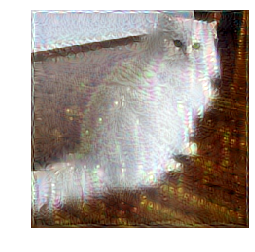

...Loss value at 1301 : 167.561
...Loss value at 1302 : 149.4089
...Loss value at 1303 : 167.7496
...Loss value at 1304 : 149.72943
...Loss value at 1305 : 167.83392
...Loss value at 1306 : 150.13208
...Loss value at 1307 : 167.86563
...Loss value at 1308 : 150.57047
...Loss value at 1309 : 167.8169
...Loss value at 1310 : 151.03001
...Loss value at 1311 : 167.52242
...Loss value at 1312 : 151.65764
...Loss value at 1313 : 166.92722
...Loss value at 1314 : 152.47217
...Loss value at 1315 : 166.39255
...Loss value at 1316 : 152.97809
...Loss value at 1317 : 165.71252
...Loss value at 1318 : 153.4011
...Loss value at 1319 : 165.17291
...Loss value at 1320 : 153.59424
...Loss value at 1321 : 164.55698
...Loss value at 1322 : 153.71132
...Loss value at 1323 : 164.14175
...Loss value at 1324 : 153.65239
...Loss value at 1325 : 163.69394
...Loss value at 1326 : 153.432
...Loss value at 1327 : 163.21603
...Loss value at 1328 : 153.06192
...Loss value at 1329 : 162.98187
...Loss value at 1330 

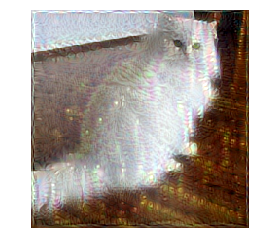

...Loss value at 1401 : 162.59512
...Loss value at 1402 : 147.36565
...Loss value at 1403 : 162.30698
...Loss value at 1404 : 147.40656
...Loss value at 1405 : 162.12729
...Loss value at 1406 : 147.42903
...Loss value at 1407 : 161.97433
...Loss value at 1408 : 147.55408
...Loss value at 1409 : 161.87534
...Loss value at 1410 : 147.73296
...Loss value at 1411 : 161.85667
...Loss value at 1412 : 147.91913
...Loss value at 1413 : 161.89807
...Loss value at 1414 : 148.15465
...Loss value at 1415 : 162.04471
...Loss value at 1416 : 148.41565
...Loss value at 1417 : 162.09119
...Loss value at 1418 : 148.69278
...Loss value at 1419 : 162.16884
...Loss value at 1420 : 148.93378
...Loss value at 1421 : 162.26532
...Loss value at 1422 : 149.0679
...Loss value at 1423 : 162.3859
...Loss value at 1424 : 149.14801
...Loss value at 1425 : 162.50552
...Loss value at 1426 : 149.0326
...Loss value at 1427 : 162.69725
...Loss value at 1428 : 148.89166
...Loss value at 1429 : 162.91086
...Loss value at 

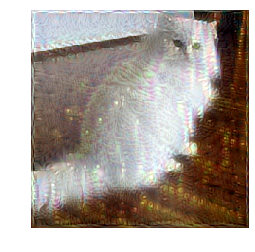

...Loss value at 1501 : 157.42352
...Loss value at 1502 : 147.58199
...Loss value at 1503 : 156.58694
...Loss value at 1504 : 147.62233
...Loss value at 1505 : 156.32417
...Loss value at 1506 : 147.85153
...Loss value at 1507 : 156.45233
...Loss value at 1508 : 148.21634
...Loss value at 1509 : 156.47128
...Loss value at 1510 : 148.33665
...Loss value at 1511 : 156.05284
...Loss value at 1512 : 148.31311
...Loss value at 1513 : 155.61426
...Loss value at 1514 : 148.33691
...Loss value at 1515 : 155.12411
...Loss value at 1516 : 148.36308
...Loss value at 1517 : 154.601
...Loss value at 1518 : 148.39645
...Loss value at 1519 : 154.16869
...Loss value at 1520 : 148.41228
...Loss value at 1521 : 153.68875
...Loss value at 1522 : 148.5219
...Loss value at 1523 : 153.35248
...Loss value at 1524 : 148.52924
...Loss value at 1525 : 152.85345
...Loss value at 1526 : 148.63904
...Loss value at 1527 : 152.42484
...Loss value at 1528 : 148.74915
...Loss value at 1529 : 152.01468
...Loss value at 

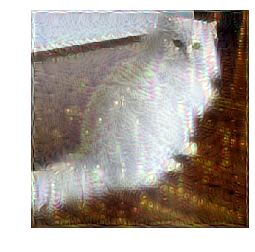

...Loss value at 1601 : 151.153
...Loss value at 1602 : 145.29422
...Loss value at 1603 : 150.76808
...Loss value at 1604 : 145.10849
...Loss value at 1605 : 150.59781
...Loss value at 1606 : 145.1146
...Loss value at 1607 : 150.77786
...Loss value at 1608 : 145.29684
...Loss value at 1609 : 151.01491
...Loss value at 1610 : 145.30777
...Loss value at 1611 : 151.38297
...Loss value at 1612 : 145.27055
...Loss value at 1613 : 151.25606
...Loss value at 1614 : 145.19554
...Loss value at 1615 : 151.06252
...Loss value at 1616 : 145.18018
...Loss value at 1617 : 150.94537
...Loss value at 1618 : 145.01617
...Loss value at 1619 : 150.79048
...Loss value at 1620 : 145.03946
...Loss value at 1621 : 150.61728
...Loss value at 1622 : 145.02057
...Loss value at 1623 : 150.60437
...Loss value at 1624 : 145.08865
...Loss value at 1625 : 150.33871
...Loss value at 1626 : 145.3421
...Loss value at 1627 : 150.06633
...Loss value at 1628 : 145.57263
...Loss value at 1629 : 149.81308
...Loss value at 1

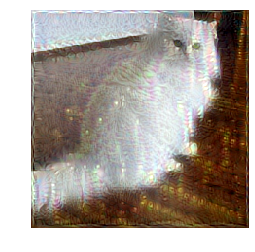

...Loss value at 1701 : 145.22522
...Loss value at 1702 : 150.35878
...Loss value at 1703 : 144.59471
...Loss value at 1704 : 150.01924
...Loss value at 1705 : 143.831
...Loss value at 1706 : 149.70578
...Loss value at 1707 : 143.14713
...Loss value at 1708 : 149.44753
...Loss value at 1709 : 142.43054
...Loss value at 1710 : 149.31165
...Loss value at 1711 : 141.98788
...Loss value at 1712 : 149.05057
...Loss value at 1713 : 141.57082
...Loss value at 1714 : 148.8034
...Loss value at 1715 : 141.21313
...Loss value at 1716 : 148.53622
...Loss value at 1717 : 140.98862
...Loss value at 1718 : 148.35336
...Loss value at 1719 : 140.81477
...Loss value at 1720 : 148.11642
...Loss value at 1721 : 140.72386
...Loss value at 1722 : 148.00099
...Loss value at 1723 : 140.65778
...Loss value at 1724 : 147.88443
...Loss value at 1725 : 140.68463
...Loss value at 1726 : 147.65051
...Loss value at 1727 : 140.79764
...Loss value at 1728 : 147.41495
...Loss value at 1729 : 140.90378
...Loss value at 

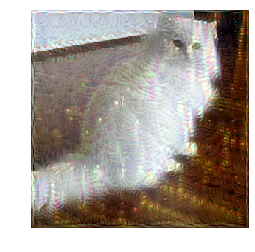

...Loss value at 1801 : 147.22006
...Loss value at 1802 : 142.2225
...Loss value at 1803 : 147.29745
...Loss value at 1804 : 141.60388
...Loss value at 1805 : 147.4091
...Loss value at 1806 : 140.97165
...Loss value at 1807 : 147.3761
...Loss value at 1808 : 140.52924
...Loss value at 1809 : 147.33142
...Loss value at 1810 : 139.98303
...Loss value at 1811 : 147.30685
...Loss value at 1812 : 139.57047
...Loss value at 1813 : 147.24625
...Loss value at 1814 : 139.10191
...Loss value at 1815 : 147.14105
...Loss value at 1816 : 138.67169
...Loss value at 1817 : 147.00175
...Loss value at 1818 : 138.32185
...Loss value at 1819 : 146.94702
...Loss value at 1820 : 137.98366
...Loss value at 1821 : 146.86856
...Loss value at 1822 : 137.87733
...Loss value at 1823 : 146.99315
...Loss value at 1824 : 137.95743
...Loss value at 1825 : 147.2752
...Loss value at 1826 : 138.23216
...Loss value at 1827 : 147.48248
...Loss value at 1828 : 138.52097
...Loss value at 1829 : 147.50027
...Loss value at 1

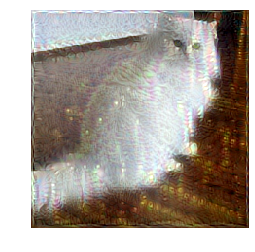

...Loss value at 1901 : 146.51062
...Loss value at 1902 : 138.18372
...Loss value at 1903 : 147.60284
...Loss value at 1904 : 138.15329
...Loss value at 1905 : 148.36838
...Loss value at 1906 : 137.8594
...Loss value at 1907 : 148.74959
...Loss value at 1908 : 137.32669
...Loss value at 1909 : 148.89062
...Loss value at 1910 : 136.6868
...Loss value at 1911 : 148.61166
...Loss value at 1912 : 136.09679
...Loss value at 1913 : 148.2951
...Loss value at 1914 : 135.42914
...Loss value at 1915 : 147.72278
...Loss value at 1916 : 134.8978
...Loss value at 1917 : 147.32693
...Loss value at 1918 : 134.40689
...Loss value at 1919 : 146.89395
...Loss value at 1920 : 133.97339
...Loss value at 1921 : 146.69908
...Loss value at 1922 : 133.6809
...Loss value at 1923 : 146.6209
...Loss value at 1924 : 133.647
...Loss value at 1925 : 146.83804
...Loss value at 1926 : 133.67879
...Loss value at 1927 : 147.22707
...Loss value at 1928 : 133.742
...Loss value at 1929 : 147.62543
...Loss value at 1930 : 

In [0]:
for i in range(2000):
  #print(loss)
  step=0.001
  loss_value, grad_values = eval_loss_and_grads(img)
  print('...Loss value at', i, ':', loss_value)
  img -= step * grad_values
  if(i%100 ==0):
    img2 = img.copy().reshape(224,224,3)
    img2 = np.clip(img2*255, 0, 255).astype('uint8')
    plt.imshow(img2)
    plt.axis('off')
    plt.show()